In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cv2
import os
from keras.callbacks import EarlyStopping
import datetime
now = datetime.datetime.now
import segmentation_models as sm

import PIL
from PIL import Image
import pathlib

from skimage.io import imread
from skimage import transform
from skimage import exposure
from skimage import io

from functools import partial
import random as rn
import argparse

import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.models import Input

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import VGG19, resnet50
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Flatten
from keras.callbacks import ReduceLROnPlateau

from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import vgg16
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
import art as art
from art.attacks.evasion import DeepFool , SaliencyMapMethod, CarliniL2Method, fast_gradient
from art.utils import load_mnist, get_labels_np_array
from art.estimators.classification import TensorFlowV2Classifier
from __future__ import print_function

from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10


os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"

Segmentation Models: using `keras` framework.


In [2]:
PATH = "C://data/german_sign/."
os.chdir(PATH);print(os.listdir(PATH))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.__version__[0] != '2':raise ImportError('This notebook requires TensorFlow v2.')

['CNN.h5', 'CNN96.h5', 'Meta', 'Meta.csv', 'r50.h5', 'R50_model1.h5', 'R50_model2.h5', 'Test', 'Test.csv', 'Train', 'Train.csv', 'untitled_project', 'VGG.h5', 'VGG_model1.h5']
Num GPUs Available:  1


In [3]:
data_dir = "C://data/german_sign/"
train_path = "C://data/german_sign//Train/"
test_path = "C://data/german_sign//Test/"

In [4]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [5]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(9, 3)

    # Plot loss
    ax[0].plot(history['loss'])
    ax[0].plot(history['val_loss'])
    ax[0].legend(['Training Loss', 'Validation Loss'])
    ax[0].set_title('Model Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')

    # Plot accuracy
    ax[1].plot(history['accuracy'])
    ax[1].plot(history['val_accuracy'])
    ax[1].legend(['Training Accuracy', 'Validation Accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')

    fig.suptitle('Model Performance')
    plt.show()
    
    
    
def process_image(image_path, height, width):
    image = imread(image_path)
    image = Image.fromarray(image, 'RGB')
    image = image.resize((height, width))
    return np.array(image) / 255


def map_pred(pred):return [int(list(train_dataset.class_indices.keys())[i]) for i in pred]
test_df = pd.read_csv(data_dir + 'Test.csv')
test_labels = test_df["ClassId"].values
imgs = test_df["Path"].values

In [6]:
batch_size = 100
height = 32; width = 32
seed = 17

data = list(map(partial(process_image, height=height, width=width), imgs))
X_test = np.array(data)

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen =  ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_dataset = train_datagen.flow_from_directory(train_path,target_size=(height, width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=seed,
                                                  color_mode='rgb',
                                                  interpolation='hamming',
                                                  subset='training')

test_dataset = test_datagen.flow_from_directory(train_path,target_size=(height, width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                seed=seed,
                                                color_mode='rgb',
                                                interpolation='hamming',
                                                subset='validation')

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [ ]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(43, activation='softmax')(x)

VGG = Model(inputs=base_model.input, outputs=predictions)
VGG.summary()

In [ ]:
VGG.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

t = now()

history = VGG.fit(train_dataset,steps_per_epoch=len(train_dataset),epochs=100, verbose=1, 
                  callbacks=[EarlyStopping(monitor='val_loss', patience = 10)],
                  validation_data=test_dataset,validation_steps=len(test_dataset))
print('Training time: %s' % (now() - t))

In [ ]:
plot_history(history.history)

In [ ]:
pred = VGG.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy VGG: ',accuracy_score(test_labels, pred)*100)

In [ ]:
VGG.save('VGG_model1.h5')

In [ ]:
base_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(43, activation='softmax')(x)

R50 = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
R50.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
R50.summary()

In [ ]:
t = now()
callbacks = [EarlyStopping(monitor='val_loss', patience = 20),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6, verbose=1)]
history = R50.fit(train_dataset,steps_per_epoch=len(train_dataset),epochs=100, verbose=1, 
                  callbacks=callbacks,
                  validation_data=test_dataset,validation_steps=len(test_dataset))
print('Training time: %s' % (now() - t))

In [ ]:
plot_history(history.history)

In [ ]:
pred = R50.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy r50: ',accuracy_score(test_labels, pred)*100)

In [ ]:
R50.save('R50_model2.h5')

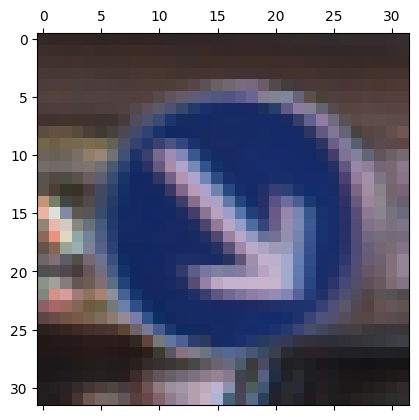

In [26]:
plt.matshow(X_test[2])
plt.show()

In [8]:
CNN96 = tf.keras.models.load_model('CNN96.h5')
pred = CNN96.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy CNN96: ',accuracy_score(test_labels, pred)*100)

395/395 [==============================] - 3s 2ms/step
Test Data accuracy CNN96:  96.15993665874902


In [9]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
classifier = TensorFlowV2Classifier(model=CNN96, nb_classes=43, input_shape=(32,32,3), loss_object=loss_object, 
                                    clip_values=(0, 1), channels_first=False)

In [10]:
attack_fgsm_CNN96 = fast_gradient.FastGradientMethod(estimator=classifier, eps=0.3)
x_test_adv_CNN96 = attack_fgsm_CNN96.generate(x=X_test)

In [11]:
pred = CNN96.predict(x_test_adv_CNN96)
pred = map_pred(pred.argmax(axis=-1))
perturbation = np.mean(np.abs((x_test_adv_CNN96 - X_test)))
print('Average perturbation: {:4.2f}'.format(perturbation))
print('Test Data accuracy CNN96 with fgsm attack {:4.2f}%'.format(accuracy_score(test_labels, pred)*100))

395/395 [==============================] - 1s 2ms/step
Average perturbation: 0.24
Test Data accuracy CNN96 with fgsm attack 10.95%


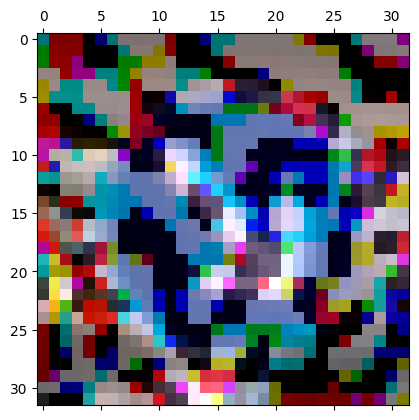

In [12]:
plt.matshow(x_test_adv_CNN96[2])
plt.show()

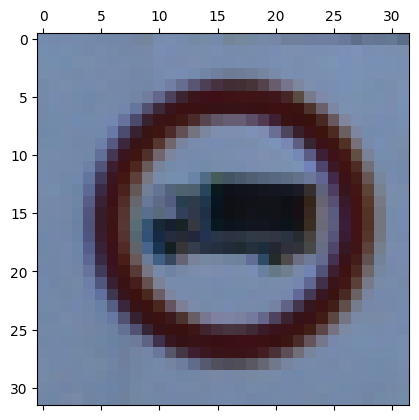

In [21]:
plt.matshow(X_test[3])
plt.show()

In [20]:
VGG = tf.keras.models.load_model('VGG_model1.h5')
pred = VGG.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy VGG: ',accuracy_score(test_labels, pred)*100)

395/395 [==============================] - 4s 9ms/step
Test Data accuracy VGG:  95.53444180522565


In [22]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
classifier = TensorFlowV2Classifier(model=VGG, nb_classes=43, input_shape=(32,32,3), loss_object=loss_object, 
                                    clip_values=(0, 1), channels_first=False)

In [23]:
attack_fgsm_VGG = fast_gradient.FastGradientMethod(estimator=classifier, eps=0.3)
x_test_adv_VGG = attack_fgsm_VGG.generate(x=X_test)

In [24]:
pred = VGG.predict(x_test_adv_VGG)
pred = map_pred(pred.argmax(axis=-1))
perturbation = np.mean(np.abs((x_test_adv_VGG - X_test)))
print('Average perturbation: {:4.2f}'.format(perturbation))
print('Test Data accuracy VGG with fgsm attack {:4.2f}%'.format(accuracy_score(test_labels, pred)*100))

395/395 [==============================] - 3s 8ms/step
Average perturbation: 0.18
Test Data accuracy VGG with fgsm attack 43.00%


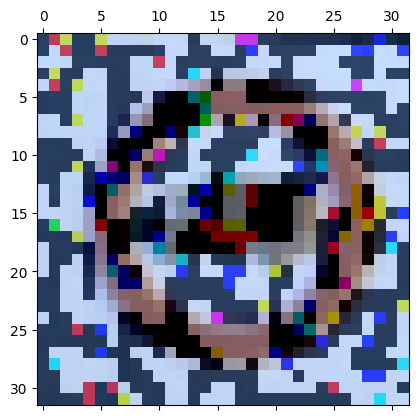

In [25]:
plt.matshow(x_test_adv_VGG[3])
plt.show()

In [19]:
R50 = tf.keras.models.load_model('R50_model2.h5')
pred = R50.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy R50: ',accuracy_score(test_labels, pred)*100)

395/395 [==============================] - 6s 9ms/step
Test Data accuracy VGG:  95.47901821060965


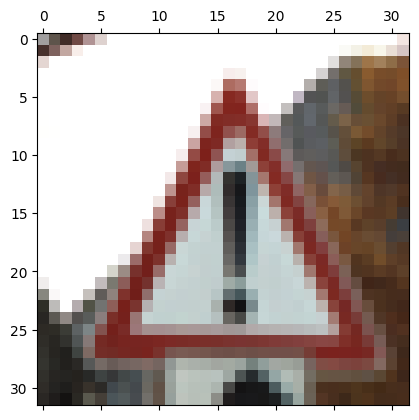

In [17]:
plt.matshow(X_test[6])
plt.show()

In [20]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
classifier = TensorFlowV2Classifier(model=R50, nb_classes=43, input_shape=(32,32,3), loss_object=loss_object, 
                                    clip_values=(0, 1), channels_first=False)

In [21]:
attack_fgsm_r50 = fast_gradient.FastGradientMethod(estimator=classifier, eps=0.3)
x_test_adv_r50 = attack_fgsm_r50.generate(x=X_test)

In [22]:
pred = R50.predict(x_test_adv_r50)
pred = map_pred(pred.argmax(axis=-1))
perturbation = np.mean(np.abs((x_test_adv_r50 - X_test)))
print('Average perturbation: {:4.2f}'.format(perturbation))
print('Test Data accuracy R50 with fgsm attack {:4.2f}%'.format(accuracy_score(test_labels, pred)*100))

395/395 [==============================] - 3s 9ms/step
Average perturbation: 0.23
Test Data accuracy R50 with fgsm attack 43.25%


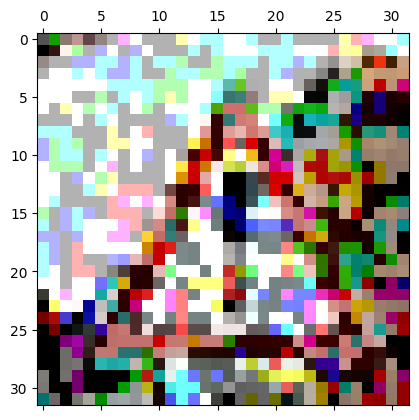

In [24]:
plt.matshow(x_test_adv_r50[6])
plt.show()